In [ ]:
# !pip install tomotopy
# import tomotopy as tp

In [ ]:
# !pip install tmplot
# import tmplot

In [2]:
import re
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from collections import Counter

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel, Phrases
from sklearn.feature_extraction.text import TfidfVectorizer
from rich.console import Console
from rich.table import Table
import pyLDAvis
import pyLDAvis.gensim

from tqdm.notebook import tqdm

# 1 Data Preprocessing

## 1-1 Load NLP data

In [86]:
#### Create the list of brand name as the search key
# {"Fiat": "_", "Mini": "Jul 9, 2019", "VW": "Feb 14, 2014", "Pg": "Feb 25, 2019"}
dic_brand = {"Pg": "Feb 25, 2019"}
date_launch = []
#### Load data by brand
for key, date in dic_brand.items():
# create paths for post and comment data
    path_comment = "/Users/xiaoc/Bayes/!_ARP/1_Preprocessing/" + key + "_comment_info_c1.csv"
    df_all = pd.read_csv(path_comment)
    date_launch.append(pd.to_datetime(date,  format="%b %d, %Y"))
print("Launch Date:", date_launch)
df_all.info()


Launch Date: [Timestamp('2019-02-25 00:00:00')]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       3174 non-null   int64  
 1   Comment_id       3174 non-null   int64  
 2   Post_id          3174 non-null   object 
 3   Author           3174 non-null   int64  
 4   Date             3174 non-null   object 
 5   Comment_Content  3174 non-null   object 
 6   Net_Likes        3174 non-null   int64  
 7   Reply_id         3174 non-null   float64
dtypes: float64(1), int64(4), object(3)
memory usage: 198.5+ KB


## 1-2 Text Tokenization with spaCy

In [79]:
#### Load spaCy package
nlp = spacy.load("en_core_web_sm")

In [87]:
#### Split text data by date
df_cmt = df_all[['Date', 'Comment_Content']]
# Convert Date column's values from string into datetime
df_cmt['Date'] = pd.to_datetime(df_cmt['Date'], format="%b %d, %Y")
# Split data
df_before = df_cmt[df_cmt['Date'] < date_launch[0]]
df_after = df_cmt[df_cmt['Date'] >= date_launch[0]]
# Store text data into a list of dataframe
l_data = [df_before["Comment_Content"], df_after["Comment_Content"]]
# Check the earliest date of the recorded comment
print(min(df_cmt['Date']))
# Check lengths
print(len(df_before), len(df_after))

2014-06-20 00:00:00
1104 2070


C:\Users\xiaoc\AppData\Local\Temp\ipykernel_10488\3435768323.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cmt['Date'] = pd.to_datetime(df_cmt['Date'], format="%b %d, %Y")


In [104]:
#### Define data preprocess function
# and token.lemma_.lower() not in {}
def preprocess(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.is_alpha
            and token.lemma_.lower() not in {"gaz","say","car","peugeot","go","think","need",
                                             "thank","know","come"}]

#### Tokenise data with spaCy for the classifier data
# Check list length before and after preprocess
tkns_docs_before = [preprocess(text) for text in tqdm(l_data[0])]
tkns_docs_after = [preprocess(text) for text in tqdm(l_data[1])]


  0%|          | 0/1104 [00:00<?, ?it/s]

  0%|          | 0/2070 [00:00<?, ?it/s]

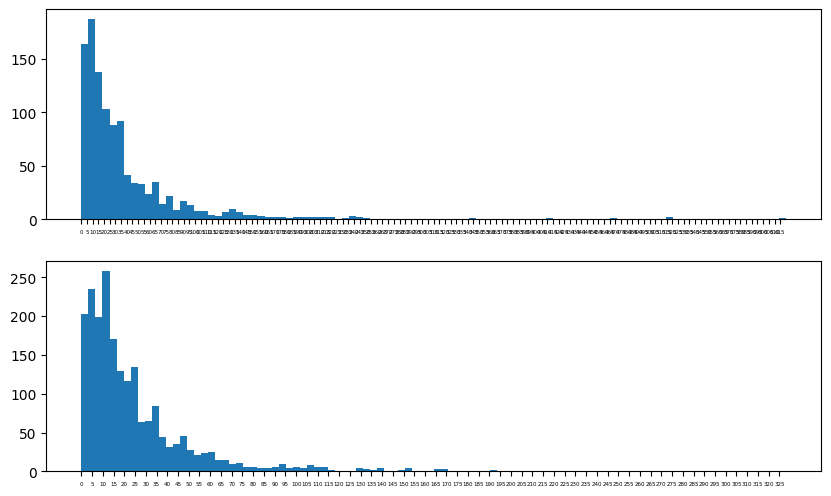

In [105]:
#### Check the distribution of the lengths
fig, axes = plt.subplots(2, 1, figsize = (10, 6))
l_len_before = [len(text) for text in tkns_docs_before]
axes[0].hist(l_len_before, bins=100)
axes[0].set_xticks(ticks=np.arange(0, max(l_len_before), step=5))
axes[0].tick_params(axis='x', labelsize=4)

l_len_after = [len(text) for text in tkns_docs_after]
axes[1].hist(l_len_after, bins=100)
axes[1].set_xticks(ticks=np.arange(0, max(l_len_after), step=5))
axes[1].tick_params(axis='x', labelsize=4)
plt.show()

In [106]:
#### Exclude texts that are too short
tkns_docs_before = [text for text in tkns_docs_before if len(text) >= 3]
tkns_docs_after = [text for text in tkns_docs_after if len(text) >= 3]
print(len(tkns_docs_before), len(tkns_docs_after))

1051 1928


In [108]:
#### Train model to capture bigram
bigram = Phrases(
    tkns_docs_before + tkns_docs_after,
    min_count=3,
    threshold=1
)
tkns_docs_before_bi = [bigram[tkn] for tkn in tkns_docs_before]
tkns_docs_after_bi = [bigram[tkn] for tkn in tkns_docs_after]

# 2 Train the model

## Approach 0: Simple EDA

### 0-1: Most Frequent Words in BoW

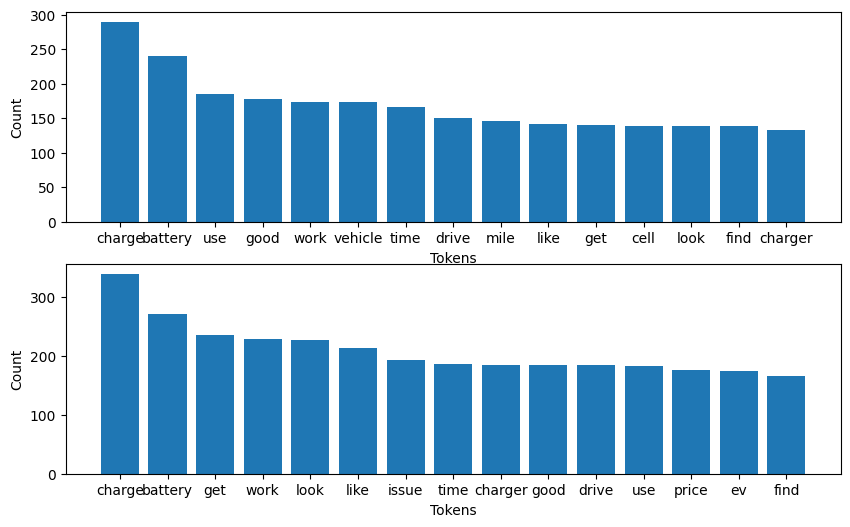

In [109]:
#### Check the most common words
flat_tkns_docs_before = [item for sublist in tkns_docs_before_bi for item in sublist]
l_cnt_before = Counter(flat_tkns_docs_before).most_common(15)
df_bow_before = pd.DataFrame(l_cnt_before, columns=["Token", "Count"])

flat_tkns_docs_after = [item for sublist in tkns_docs_after_bi for item in sublist]
l_cnt_after = Counter(flat_tkns_docs_after).most_common(15)
df_bow_after = pd.DataFrame(l_cnt_after, columns=["Token", "Count"])

#### Visualise the common tokens
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
axes[0].bar(df_bow_before['Token'], df_bow_before['Count'])
axes[0].set_xlabel('Tokens')
axes[0].set_ylabel('Count')
axes[1].bar(df_bow_after['Token'], df_bow_after['Count'])
axes[1].set_xlabel('Tokens')
axes[1].set_ylabel('Count')
plt.show()

## Approach 1: Gensim

### 1-1 Create necessary documents

In [110]:
# Create a dictionary representation of the documents
dic_before = Dictionary(tkns_docs_before_bi)
dic_after = Dictionary(tkns_docs_after_bi)
# Filter out words that occur less than 20 documents, or more than 50% of the documents
dic_before.filter_extremes(no_below=3, no_above=0.5)
dic_after.filter_extremes(no_below=3, no_above=0.5)
# Create bag-of-words representation of the documents (Corpus)
corpus_before = [dic_before.doc2bow(doc) for doc in tkns_docs_before_bi]
corpus_after = [dic_after.doc2bow(doc) for doc in tkns_docs_after_bi]

### 1-2 Iterate the Optimal Number of Topics

In [111]:
# Loop through different numbers of topics
cvs_before = {}
cvs_after = {}
for topic_number in range(3, 13, 1):
    # Create and train the LDA model
    lda_model_before = LdaModel(corpus=corpus_before, id2word=dic_before, num_topics=topic_number, passes=20, random_state=11)
    lda_model_after = LdaModel(corpus=corpus_after, id2word=dic_after, num_topics=topic_number, passes=20, random_state=11)
    # Calculate coherence score u_mass & c_v ?
    coherence_model_before = CoherenceModel(model=lda_model_before, texts=tkns_docs_before_bi, dictionary=dic_before, coherence='c_v')
    coherence_before = coherence_model_before.get_coherence()
    coherence_model_after = CoherenceModel(model=lda_model_after, texts=tkns_docs_after_bi, dictionary=dic_after, coherence='c_v')
    coherence_after = coherence_model_after.get_coherence()
    # Store coherence value
    cvs_before[topic_number] = coherence_before
    cvs_after[topic_number] = coherence_after
    print(f'Number of Topics: {topic_number}\tCoherence Score 1: {coherence_before}\tCoherence Score 2: {coherence_after}')

Number of Topics: 3	Coherence Score 1: 0.355186019509311	Coherence Score 2: 0.45162054622883147
Number of Topics: 4	Coherence Score 1: 0.34631769383041716	Coherence Score 2: 0.48419462383248413
Number of Topics: 5	Coherence Score 1: 0.32895266609401097	Coherence Score 2: 0.4527428623085455
Number of Topics: 6	Coherence Score 1: 0.35437413534000006	Coherence Score 2: 0.4423052872669231
Number of Topics: 7	Coherence Score 1: 0.34868482131150075	Coherence Score 2: 0.42748356392857945
Number of Topics: 8	Coherence Score 1: 0.36380841542689013	Coherence Score 2: 0.34841630001172263
Number of Topics: 9	Coherence Score 1: 0.36510312425086644	Coherence Score 2: 0.44992463103138924
Number of Topics: 10	Coherence Score 1: 0.34335644282322525	Coherence Score 2: 0.43367496808380157
Number of Topics: 11	Coherence Score 1: 0.3555426475513425	Coherence Score 2: 0.39810590508267923
Number of Topics: 12	Coherence Score 1: 0.34747467915065183	Coherence Score 2: 0.4013157529474037


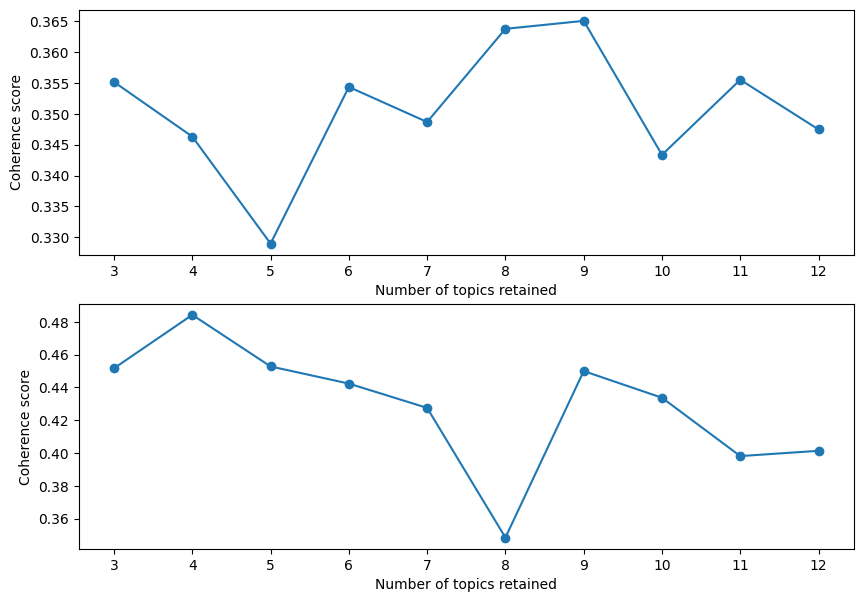

In [112]:
#### Visualise the coherence scores
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
axes[0].plot(cvs_before.keys(), cvs_before.values(), "o-")
axes[0].set_xlabel("Number of topics retained")
axes[0].set_ylabel("Coherence score")
axes[0].set_xticks(range(3, 13, 1))
axes[1].plot(cvs_after.keys(), cvs_after.values(), "o-")
axes[1].set_xlabel("Number of topics retained")
axes[1].set_ylabel("Coherence score")
axes[1].set_xticks(range(3, 13, 1))
plt.show()

In [118]:
#### Train the model with the best topic numbers
num_topic_before = 9
num_topic_after = 4
best_mdl_before = LdaModel(corpus=corpus_before, id2word=dic_before, num_topics=num_topic_before, passes=20, random_state=11)
best_mdl_after = LdaModel(corpus=corpus_after, id2word=dic_after, num_topics=num_topic_after, passes=20, random_state=11)

In [119]:
#### Exhibit most related tokens under each topic before the date
console = Console()
word_num = 8
table = Table(
    show_header=True,
    header_style="cyan",
    title=f"[bold] [cyan] BEFORE: Word to topic probabilities (top {word_num} words)[/cyan]",
    width=130,
)
table.add_column("Topic", justify="center", style="cyan", width=15)
for i in range(1, word_num+2):
    table.add_column(f"W {i}", width=20)
# Obtain the top N words for each topic
topics = best_mdl_before.show_topics(formatted=False, num_topics=num_topic_before, num_words=word_num)
for k, topic in topics:
    values = [f"{word}\n({np.round(prob, 5)})\n" for word, prob in topic]
    table.add_row(str(k+1), *values)

console.print(table)

                                         BEFORE: Word to topic probabilities (top 8 words)                         
┏━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━
┃ Topic ┃ W 1        ┃ W 2        ┃ W 3         ┃ W 4        ┃ W 5         ┃ W 6        ┃ W 7         ┃ W 8        
┡━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━
│   1   │ seat       │ send_sm    │ tapatalk    │ leaf       │ ion         │ work       │ good        │ look       
│       │ (0.025860… │ (0.013229… │ (0.0131500… │ (0.012550… │ (0.0098000… │ (0.007840… │ (0.0071100… │ (0.007079… 
│       │            │            │             │            │             │            │             │            
│   2   │ spring     │ charge     │ heater      │ good       │ get         │ air        │ fit         │ coil       
│       │ (0.019409… │ (0.009809… │ (0.0093799… │ (0.008770… │ (0.0083400… │ (0.007890… │ (0.0070500… │ (0.006810… 
│       │            │            │             │            │             │            │             │            
│   3   │ battery    │ drive      │ good        │ use        │ problem     │ like       │ start       │ electric   
│       │ (0.012810… │ (0.010099… │ (0.0073799… │ (0.007350… │ (0.0059899… │ (0.005650… │ (0.0055599… │ (0.005429… 
│       │            │            │             │            │             │            │             │            
│   4   │ charge     │ buy        │ time        │ ev         │ power       │ voltage    │ torque      │ ion        
│       │ (0.008589… │ (0.008469… │ (0.0083799… │ (0.007869… │ (0.0064300… │ (0.005840… │ (0.0056400… │ (0.005570… 
│       │            │            │             │            │             │            │             │            
│   5   │ charge     │ work       │ sell        │ time       │ ion         │ take       │ range       │ mile       
│       │ (0.016170… │ (0.006560… │ (0.0065199… │ (0.006510… │ (0.0063800… │ (0.006240… │ (0.0060399… │ (0.005950… 
│       │            │            │             │            │             │            │             │            
│   6   │ rx_bad     │ st_rx      │ bad_st      │ run        │ error       │ ah_acc     │ charge      │ low        
│       │ (0.020940… │ (0.015479… │ (0.0141899… │ (0.007639… │ (0.0074900… │ (0.007110… │ (0.0071000… │ (0.007000… 
│       │            │            │             │            │             │            │             │            
│   7   │ run        │ use        │ work        │ mike       │ price       │ bad        │ find        │ tell       
│       │ (0.006510… │ (0.006289… │ (0.0060299… │ (0.005880… │ (0.0056500… │ (0.005419… │ (0.0053400… │ (0.005260… 
│       │            │            │             │            │             │            │             │            
│   8   │ vehicle    │ charger    │ battery     │ charge     │ single_pha… │ phase      │ allied      │ cell       
│       │ (0.015760… │ (0.012690… │ (0.0103799… │ (0.010029… │ (0.0083699… │ (0.007919… │ (0.0078999… │ (0.007340… 
│       │            │            │             │            │             │            │             │            
│   9   │ year       │ point      │ pin         │ find       │ charge      │ cover      │ battery     │ ev         
│       │ (0.009039… │ (0.007819… │ (0.0077700… │ (0.006959… │ (0.0069499… │ (0.006800… │ (0.0066999… │ (0.006310… 
│       │            │            │             │            │             │            │             │            
└───────┴────────────┴────────────┴─────────────┴────────────┴─────────────┴────────────┴─────────────┴────────────

In [120]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_mdl_before, corpus_before, dic_before)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.025273  0.057051       1        1  20.490693
2     -0.020361 -0.012750       2        1  13.163897
4     -0.029226 -0.015447       3        1  12.579610
8     -0.030551 -0.033865       4        1  12.003826
3     -0.017586 -0.027472       5        1  11.639529
5      0.252160 -0.004011       6        1   8.470642
1     -0.049175  0.170730       7        1   7.792576
6     -0.005941 -0.019375       8        1   7.241729
0     -0.074046 -0.114861       9        1   6.617498, topic_info=         Term       Freq       Total Category  logprob  loglift
969      seat  87.000000   87.000000  Default  30.0000  30.0000
2077   rx_bad  59.000000   59.000000  Default  29.0000  29.0000
1240   spring  65.000000   65.000000  Default  28.0000  28.0000
2081    st_rx  44.000000   44.000000  Default  27.0000  27.0000
2051   bad_st  40.000000   40.000000  Default  26.0000  26.0000
...       ...        ...         ...      ...      ...      ...
267       get  12.047132  129.858093   Topic9  -5.1994   0.3378
118     drive  11.498711  140.441956   Topic9  -5.2460   0.2129
245       bit   9.642550  108.921688   Topic9  -5.4221   0.2910
193   battery  10.292629  226.333510   Topic9  -5.3568  -0.3751
1         try   8.971453  112.176665   Topic9  -5.4942   0.1894

[638 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2192      6  0.939554     acc_chg
1616      1  0.107684   accessory
1616      2  0.753788   accessory
1588      4  0.805984  achievable
2047      6  0.925178     adc_adc
...     ...       ...         ...
929       1  0.789394       zivan
929       3  0.166188       zivan
37        2  0.182034         zoe
37        3  0.485425         zoe
37        9  0.242713         zoe

[1736 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 5, 9, 4, 6, 2, 7, 1])

In [122]:
#### Exhibit most related tokens under each topic after the date
console = Console()
word_num = 8
table = Table(
    show_header=True,
    header_style="cyan",
    title=f"[bold] [cyan] AFTER: Word to topic probabilities (top {word_num} words)[/cyan]",
    width=130,
)
table.add_column("Topic", justify="center", style="cyan", width=15)
for i in range(1, word_num+2):
    table.add_column(f"W {i}", width=20)
# Obtain the top N words for each topic
topics = best_mdl_after.show_topics(formatted=False, num_topics=num_topic_after, num_words=word_num)
for k, topic in topics:
    values = [f"{word}\n({np.round(prob, 5)})\n" for word, prob in topic]
    table.add_row(str(k+1), *values)

console.print(table)

                                          AFTER: Word to topic probabilities (top 8 words)                         
┏━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━
┃ Topic ┃ W 1        ┃ W 2        ┃ W 3         ┃ W 4        ┃ W 5         ┃ W 6        ┃ W 7         ┃ W 8        
┡━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━
│   1   │ battery    │ price      │ range       │ ev         │ drive       │ get        │ issue       │ charge     
│       │ (0.012079… │ (0.007679… │ (0.0068999… │ (0.006740… │ (0.0066900… │ (0.006570… │ (0.0062600… │ (0.006029… 
│       │            │            │             │            │             │            │             │            
│   2   │ charge     │ battery    │ voltage     │ fault      │ work        │ ion        │ forum       │ problem    
│       │ (0.009789… │ (0.007369… │ (0.0073099… │ (0.006670… │ (0.0065799… │ (0.005429… │ (0.0054000… │ (0.004960… 
│       │            │            │             │            │             │            │             │            
│   3   │ look       │ find       │ tapatalk    │ option     │ price       │ motor      │ wire        │ van        
│       │ (0.007249… │ (0.006800… │ (0.0062199… │ (0.006219… │ (0.0059000… │ (0.005650… │ (0.0056300… │ (0.005630… 
│       │            │            │             │            │             │            │             │            
│   4   │ charge     │ charger    │ work        │ get        │ like        │ good       │ look        │ use        
│       │ (0.012020… │ (0.011330… │ (0.0071999… │ (0.006750… │ (0.0062600… │ (0.006169… │ (0.0057999… │ (0.005410… 
│       │            │            │             │            │             │            │             │            
└───────┴────────────┴────────────┴─────────────┴────────────┴─────────────┴────────────┴─────────────┴────────────

In [123]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_mdl_after, corpus_after, dic_after)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.046039 -0.056920       1        1  34.727430
0      0.049071 -0.075068       2        1  26.133594
2      0.064494  0.122134       3        1  20.247415
1     -0.159604  0.009854       4        1  18.891561, topic_info=         Term        Freq       Total Category  logprob  loglift
133   charger  174.000000  174.000000  Default  30.0000  30.0000
14   tapatalk   53.000000   53.000000  Default  29.0000  29.0000
565   voltage   81.000000   81.000000  Default  28.0000  28.0000
253    charge  319.000000  319.000000  Default  27.0000  27.0000
243      wire   58.000000   58.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
614   contact   26.722179   55.321267   Topic4  -5.6825   0.9388
378     start   30.897560  139.254103   Topic4  -5.5373   0.1608
169      plug   28.798023   95.237154   Topic4  -5.6077   0.4704
2       order   27.284287  118.139572   Topic4  -5.6617   0.2009
91      issue   26.997174  181.408721   Topic4  -5.6722  -0.2386

[319 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1909      2  0.857279  activate
1909      4  0.142880  activate
2189      1  0.103411    allied
2189      2  0.051705    allied
2189      3  0.827287    allied
...     ...       ...       ...
595       1  0.263315       yes
595       2  0.297660       yes
595       3  0.377799       yes
595       4  0.057242       yes
2900      1  0.913545   zap_map

[619 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

In [124]:
#### Get the highest topic probability contribution of each text
def format_topics_sentences(ldamodel=lda_model_before, corpus=corpus_before, texts=l_data[0]):
    # Init output
    sent_topics = []

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                tmp_info = {'Dominant_Topic':int(topic_num), 'Perc_Contribution':round(prop_topic,4), 'Topic_Keywords':topic_keywords}
                sent_topics.append(tmp_info)
            else:
                break
    sent_topics_df = pd.DataFrame(sent_topics)

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# Get dataframes of topics before and after the date
df_topic_sents_keywords_before = format_topics_sentences(ldamodel=best_mdl_before, corpus=corpus_before, texts=l_data[0])
# Format
df_dominant_topic_before = df_topic_sents_keywords_before.reset_index()
df_dominant_topic_before.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_topic_sents_keywords_after = format_topics_sentences(ldamodel=best_mdl_after, corpus=corpus_after, texts=l_data[1])
# Format
df_dominant_topic_after = df_topic_sents_keywords_after.reset_index()
df_dominant_topic_after.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [125]:
#### Find the top 5 representative document for each topic
# Sort values within groups
df_top_topic_before = df_dominant_topic_before.sort_values(['Dominant_Topic', 'Topic_Perc_Contrib'], ascending=[True, False])
# Get top 5 for each group
top_records_before = df_top_topic_before.groupby('Dominant_Topic').head(5)
top_records_before.to_csv(f"{list(dic_brand.keys())[0]}_Top_records_before.csv", header=True)

# Sort values within groups
df_top_topic_after = df_dominant_topic_after.sort_values(['Dominant_Topic', 'Topic_Perc_Contrib'], ascending=[True, False])
# Get top 5 for each group
top_records_after = df_top_topic_after.groupby('Dominant_Topic').head(5)
top_records_after.to_csv(f"{list(dic_brand.keys())[0]}_Top_records_after.csv", header=True)

In [1]:
# #### Check topic distribution across documents
# # Number of Documents for Each Topic
# topic_counts = df_dominant_topic['Dominant_Topic'].value_counts()
# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)*100

# # Merge dataframes
# df_topic_stat = pd.DataFrame(topic_counts).merge(topic_contribution, on="Dominant_Topic", how="left")
# # Change column names
# df_topic_stat = df_topic_stat.reset_index()
# df_topic_stat.columns = ['Dominant_Topic', 'Num_Documents', 'Perc_Documents']

# # Show
# df_topic_stat